       expiry  side       contractSymbol             lastTradeDate  strike  \
0  2025-08-29  call  AAPL250829C00110000 2025-08-06 16:10:15+00:00   110.0   
1  2025-08-29  call  AAPL250829C00120000 2025-08-22 18:34:39+00:00   120.0   
2  2025-08-29  call  AAPL250829C00125000 2025-08-15 19:50:00+00:00   125.0   
3  2025-08-29  call  AAPL250829C00130000 2025-08-22 18:28:57+00:00   130.0   
4  2025-08-29  call  AAPL250829C00135000 2025-08-15 19:50:00+00:00   135.0   

   lastPrice  bid  ask  change  percentChange  volume  openInterest  \
0     105.00  0.0  0.0     0.0            0.0     3.0             7   
1     108.25  0.0  0.0     0.0            0.0     3.0            16   
2     106.45  0.0  0.0     0.0            0.0     1.0             8   
3      98.05  0.0  0.0     0.0            0.0     2.0             7   
4      96.50  0.0  0.0     0.0            0.0     1.0             9   

   impliedVolatility  inTheMoney contractSize currency  
0            0.00001        True      REGULAR  

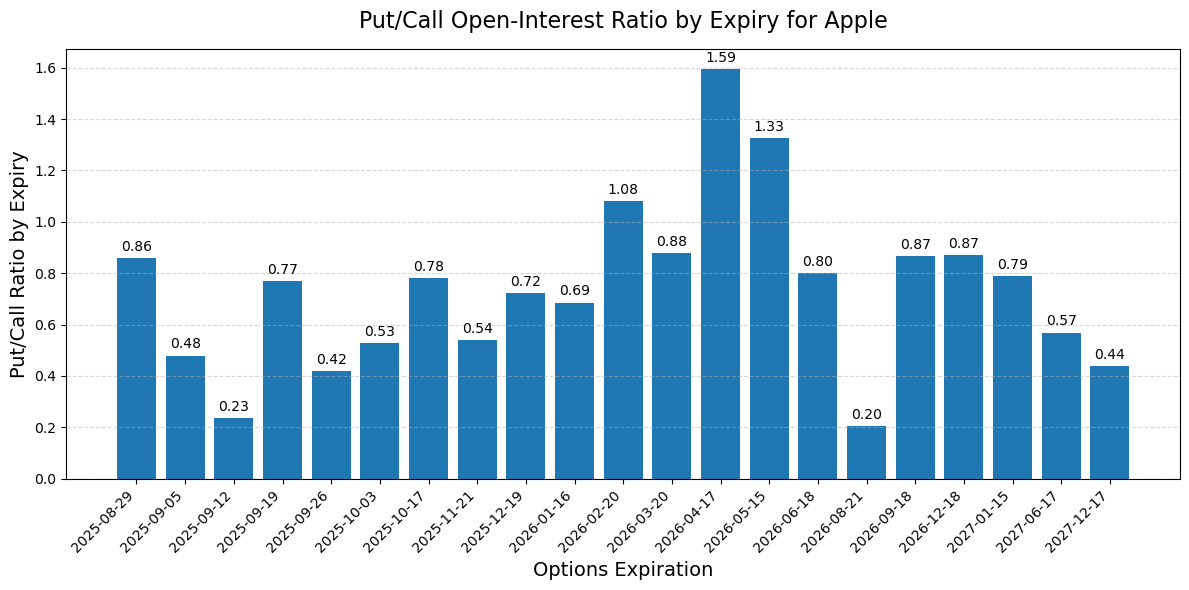

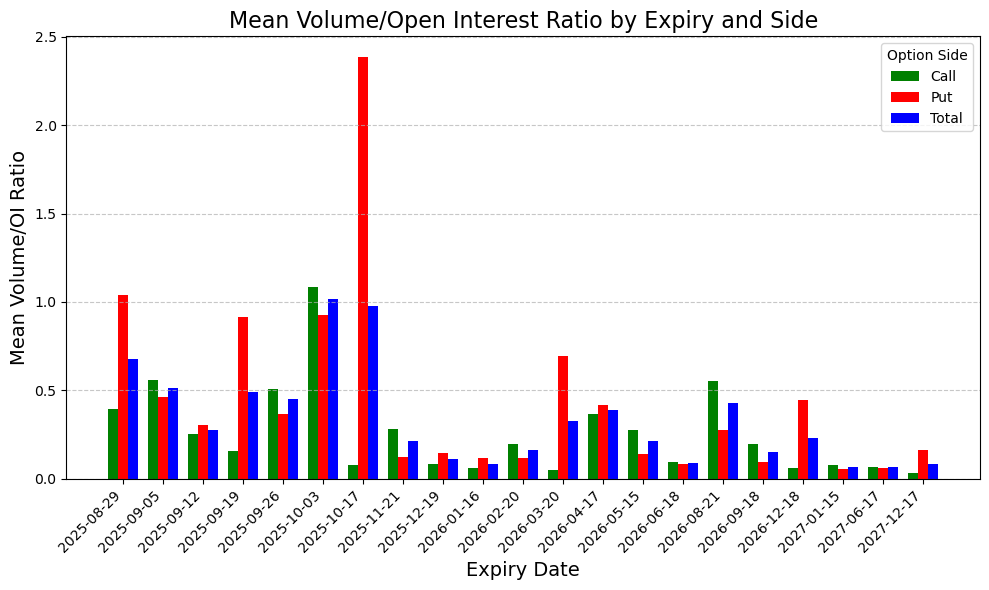

We see peaks in years: 2025 , suggesting worries of downside volatility in the AAPL stock.


In [21]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

#start initializing ticker
ticker = yf.Ticker("AAPL")

#collect all chains
all_chains = []
for expiry in ticker.options:
    chain = ticker.option_chain(expiry)
    # tag each row with its expiry date
    calls = chain.calls.copy().assign(expiry=expiry, side='call')
    puts = chain.puts.copy().assign(expiry=expiry, side ='put')
    all_chains.extend([calls, puts])

#concatenate into one DataFrame
options_df = pd.concat(all_chains, ignore_index=True)

#reoder columns so expiry/side come first
cols = ['expiry', 'side'] + [c for c in options_df.columns if c not in ('expiry', 'side')]
options_df = options_df[cols]

print(options_df.head())


#calculate the PC-ratio
#group by earliest expiry first
oi_by_side = (
    options_df
    .groupby(['expiry', 'side'])['openInterest']
    .sum()
    .unstack('side')
)

oi_by_side['PCR_OI'] = oi_by_side['put'] / oi_by_side['call']

oi_by_side.index = pd.to_datetime(oi_by_side.index)
oi_by_side = oi_by_side.sort_index()

print(oi_by_side[['call', 'put', 'PCR_OI']])




#calculate volume to open ineterst rate ratio 
options_df['vol_to_oi'] = np.where(
    options_df['openInterest'] > 0,
    options_df['volume'] / options_df['openInterest'],
    np.nan
)

#group by expiry and side
ratio_by_side = (
    options_df
      .groupby(['expiry', 'side'])['vol_to_oi']
      .mean()
      .unstack(level = 'side')
)

#calculate the total per expiry
total_ratio = (
    options_df
    .groupby('expiry')['vol_to_oi']
    .mean()
    .rename('total')
)

ratio_summary = pd.concat([ratio_by_side, total_ratio], axis=1).sort_index()

print(ratio_summary)



#print PE-Ratio:
labels = oi_by_side.index.strftime('%Y-%m-%d')


fig, ax = plt.subplots(figsize=(12, 6))

bars = ax.bar(labels, oi_by_side['PCR_OI'])


ax.set_title('Put/Call Open‑Interest Ratio by Expiry for Apple', fontsize=16, pad=15)
ax.set_xlabel('Options Expiration', fontsize=14)
ax.set_ylabel('Put/Call Ratio by Expiry', fontsize=14)


ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),              # 3 points vertical offset
                textcoords='offset points',
                ha='center', va='bottom',
                fontsize=10)

plt.tight_layout()
plt.show()


#plot vol-oi-ratio
ratio_summary.index = pd.to_datetime(ratio_summary.index)


x = np.arange(len(ratio_summary.index))
width = 0.25
# plot unsual options activity
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, ratio_summary['call'], width, label='Call', color='green')
ax.bar(x,       ratio_summary['put'],  width, label='Put',  color='red')
ax.bar(x + width, ratio_summary['total'], width, label='Total',color='blue')


ax.set_title('Mean Volume/Open Interest Ratio by Expiry and Side', fontsize=16)
ax.set_xlabel('Expiry Date', fontsize=14)
ax.set_ylabel('Mean Volume/OI Ratio', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(
    ratio_summary.index.strftime('%Y-%m-%d'),  
    rotation=45, ha='right'
)
ax.legend(title='Option Side')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()



#comments on the graph
peak_dates = ratio_summary['total'].nlargest(3).index
peak_years = peak_dates.year.unique()
print('We see peaks in years:', ', '.join(map(str, peak_years)),
      ', suggesting worries of downside volatility in the AAPL stock.')